In [34]:
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

from tensorflow import keras

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier
from pickle import dump

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [35]:
to_keep = [i for i in range(0, 519)]
data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0, usecols=to_keep)
print(data.shape)

(1904, 519)


In [36]:
# Define class for the classification class "death_from_cancer"
data['death_from_cancer'].replace({'Living': 0, 'Died of Other Causes': 1, 'Died of Disease': 2}, inplace=True)

In [37]:
# Imputation of missing values with 'mode' values in important columns
cols_to_fill = ["type_of_breast_surgery", "cancer_type_detailed", "cellularity", "er_status_measured_by_ihc", 
                "neoplasm_histologic_grade", "tumor_other_histologic_subtype", "primary_tumor_laterality", 
                "mutation_count", "3-gene_classifier_subtype", "tumor_size", "tumor_stage"]
for col in cols_to_fill:
    data[col] = data[col].fillna(data[col].mode()[0])

In [38]:
df = data.copy(deep = True)

# Convert strings into categorial classes
cols_to_convert = ["type_of_breast_surgery", "cellularity", "er_status_measured_by_ihc", "her2_status",
                 "inferred_menopausal_state","pr_status"]

replace_dict = {"type_of_breast_surgery": {'BREAST CONSERVING': 1, 'MASTECTOMY': 0},
                "cellularity": {'High': 2, 'Moderate': 1, 'Low': 0},
                "er_status_measured_by_ihc": {'Positve': 1, 'Negative': 0},
                "her2_status": {'Positive': 1, 'Negative': 0},
                "inferred_menopausal_state": {'Post': 1, 'Pre': 0},
                "pr_status": {'Positive': 1, 'Negative': 0}}

for col in cols_to_convert:
    df[col].replace(replace_dict[col], inplace=True)

In [39]:
#Use One Hot Encoding to convert categorical features into numeric features

df = pd.get_dummies(data = df, columns = ['cancer_type','cancer_type_detailed', 'er_status', 'her2_status_measured_by_snp6', 'pam50_+_claudin-low_subtype','tumor_other_histologic_subtype', 'integrative_cluster', 'primary_tumor_laterality', '3-gene_classifier_subtype'])

In [40]:
# drop rows with missing values
df.dropna(inplace=True)
print(df.shape)

(1888, 556)


In [41]:
# b) Feature Selection
# Select the top k most relevant features (largest values)
def select_features(X, y, features):
# configure to select all features
    fs = SelectKBest(score_func=f_classif, k=10)
    
# learn relationship from training data
    fs.fit(X, y)
    
    df_scores = pd.DataFrame(fs.scores_)
    df_columns = pd.DataFrame(X.columns)
    
    feature_scores = pd.concat([df_columns,df_scores], axis=1)
    feature_scores.columns = ['fname','score']
    
    best_features = feature_scores.nlargest(features,'score')
    
    X_featured = pd.DataFrame()  
    for j in best_features['fname']:
        X_featured[j] = X[j]

    X = X_featured.copy()
    #X = np.array(X)    
    #y = np.array(y)
    
    # plot feature scores
    a = best_features['fname']
    b= best_features['score']    
    plt.bar(a, b)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return X, y, fs

/home/haziqfaiz/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


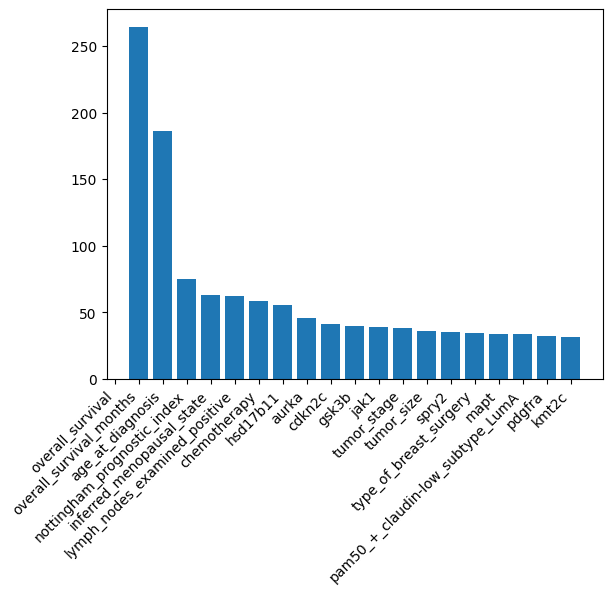

In [42]:
# c) Split the dataset into train and test sets 
X = df.drop(columns=['death_from_cancer', 'patient_id', 'oncotree_code'], axis = 1)
y = df['death_from_cancer']

X, y, fs = select_features(X, y, 20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [22]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1416, 20) (472, 20)
(1416,) (472,)


In [125]:
#b) Deep learning model (Keras Sequential)
# Define a model with 3 layers and dropout regulation
NN_model_1 = keras.Sequential([    
    keras.layers.Dense(300, input_shape = (20, ), activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(150, activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='softplus')  
])

NN_model_1.compile(optimizer = 'adam',
                loss = 'mean_squared_logarithmic_error',
                metrics=['mse'])

In [126]:
# fit the keras model on the dataset
model_1_fit = NN_model_1.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=50, batch_size=64)

Epoch 1/50
23/23 [==============================] - 1s 8ms/step - loss: 0.2577 - mse: 0.7436 - val_loss: 0.2506 - val_mse: 0.7627
Epoch 2/50
23/23 [==============================] - 0s 4ms/step - loss: 0.2577 - mse: 0.7436 - val_loss: 0.2506 - val_mse: 0.7627
Epoch 3/50
23/23 [==============================] - 0s 3ms/step - loss: 0.2577 - mse: 0.7436 - val_loss: 0.2506 - val_mse: 0.7627
Epoch 4/50
23/23 [==============================] - 0s 3ms/step - loss: 0.2577 - mse: 0.7436 - val_loss: 0.2506 - val_mse: 0.7627
Epoch 5/50
23/23 [==============================] - 0s 4ms/step - loss: 0.2577 - mse: 0.7436 - val_loss: 0.2506 - val_mse: 0.7627
Epoch 6/50
23/23 [==============================] - 0s 3ms/step - loss: 0.2577 - mse: 0.7436 - val_loss: 0.2506 - val_mse: 0.7627
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 0.2577 - mse: 0.7436 - val_loss: 0.2506 - val_mse: 0.7627
Epoch 8/50
23/23 [==============================] - 0s 3ms/step - loss: 0.2577 - mse: 0.74

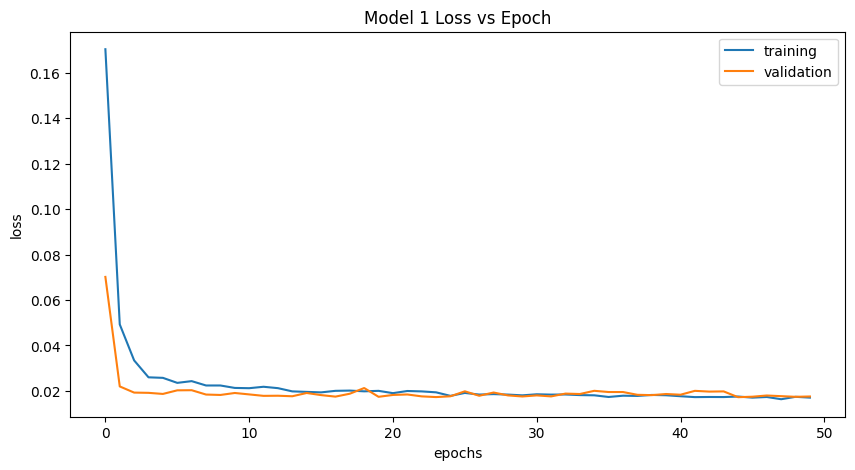

In [122]:
# Plot learning curve
plt.figure(figsize = (10, 5))
plt.plot(model_1_fit.history['loss'], label = 'training')
plt.plot(model_1_fit.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model 1 Loss vs Epoch')
plt.legend()

In [127]:
predictions=(NN_model_1.predict(X_test)).astype("int32")

15/15 [==============================] - 0s 1ms/step


In [128]:
predictions

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

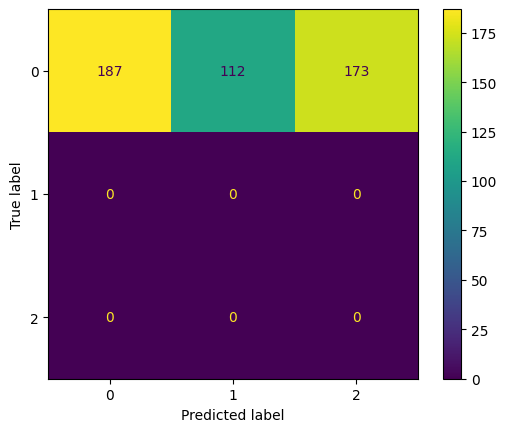

In [129]:
cm = confusion_matrix(predictions,y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [85]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=20, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(300,activation='relu'))

model.add(layers.Dropout(0.4))

model.add(layers.Dense(1,activation='softplus'))


model.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          1280      
                                                                 
 lstm_6 (LSTM)               (None, 128)               98816     
                                                                 
 dense_40 (Dense)            (None, 300)               38700     
                                                                 
 dropout_24 (Dropout)        (None, 300)               0         
                                                                 
 dense_41 (Dense)            (None, 1)                 301       
                                                                 
Total params: 139,097
Trainable params: 139,097
Non-trainable params: 0
_________________________________________________________________


In [86]:
model_2_fit = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=50, batch_size=64)

Epoch 1/50
23/23 [==============================] - 2s 37ms/step - loss: 1.0566e-07 - accuracy: 0.2564 - val_loss: 1.1567e-07 - val_accuracy: 0.2373
Epoch 2/50
23/23 [==============================] - 0s 20ms/step - loss: 1.0566e-07 - accuracy: 0.2564 - val_loss: 1.1567e-07 - val_accuracy: 0.2373
Epoch 3/50
23/23 [==============================] - 0s 19ms/step - loss: 1.0566e-07 - accuracy: 0.2564 - val_loss: 1.1567e-07 - val_accuracy: 0.2373
Epoch 4/50
23/23 [==============================] - 0s 19ms/step - loss: 1.0566e-07 - accuracy: 0.2564 - val_loss: 1.1567e-07 - val_accuracy: 0.2373
Epoch 5/50
23/23 [==============================] - 0s 19ms/step - loss: 1.0566e-07 - accuracy: 0.2564 - val_loss: 1.1567e-07 - val_accuracy: 0.2373
Epoch 6/50
23/23 [==============================] - 0s 21ms/step - loss: 1.0566e-07 - accuracy: 0.2564 - val_loss: 1.1567e-07 - val_accuracy: 0.2373
Epoch 7/50
23/23 [==============================] - 1s 22ms/step - loss: 1.0566e-07 - accuracy: 0.2564 - v

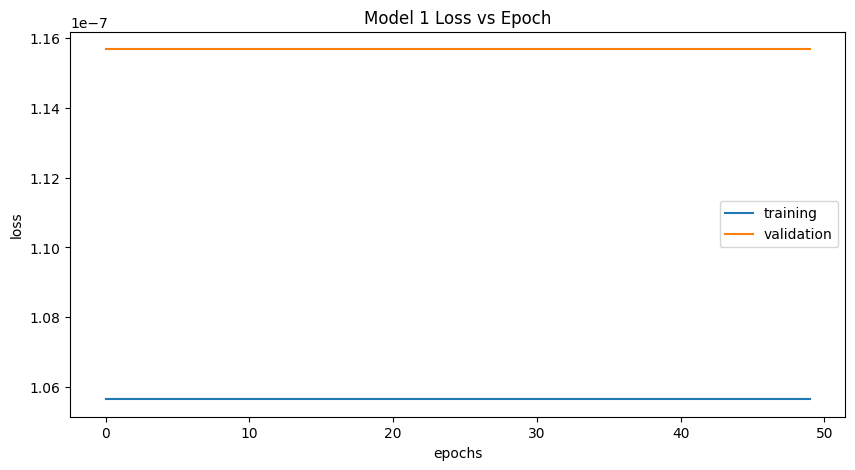

In [87]:
# Plot learning curve
plt.figure(figsize = (10, 5))
plt.plot(model_2_fit.history['loss'], label = 'training')
plt.plot(model_2_fit.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model 1 Loss vs Epoch')
plt.legend()

In [88]:
loss, accuracy = model.evaluate(y_test)
accuracy

ValueError: in user code:

    File "/home/haziqfaiz/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "/home/haziqfaiz/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/haziqfaiz/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "/home/haziqfaiz/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1756, in test_step
        y_pred = self(x, training=False)
    File "/home/haziqfaiz/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/haziqfaiz/.local/lib/python3.10/site-packages/keras/engine/input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_17' (type Sequential).
    
    Input 0 of layer "lstm_6" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)
    
    Call arguments received by layer 'sequential_17' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None


In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [65]:
predictions=(model.predict(X_test) > 0.5).astype("int32")

15/15 [==============================] - 0s 5ms/step


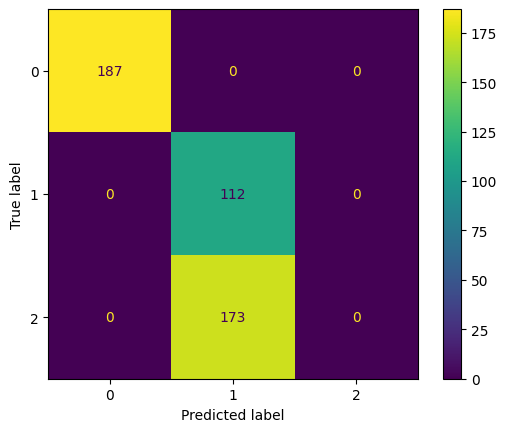

In [69]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [70]:
predictions

array([[0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
    

In [71]:
y_test

array([0., 2., 2., 0., 2., 0., 1., 0., 1., 1., 0., 1., 2., 1., 1., 1., 1.,
       0., 2., 2., 0., 2., 1., 0., 0., 0., 0., 1., 2., 1., 2., 1., 0., 2.,
       1., 0., 2., 2., 2., 1., 1., 1., 1., 2., 2., 1., 0., 1., 2., 0., 0.,
       1., 1., 0., 2., 2., 2., 2., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 1., 2., 2., 1., 1., 1., 0., 1., 1., 0., 1., 2., 2.,
       1., 0., 2., 2., 2., 0., 2., 2., 2., 2., 2., 0., 2., 2., 0., 0., 0.,
       2., 1., 0., 2., 1., 2., 0., 1., 2., 2., 0., 0., 0., 2., 2., 0., 1.,
       2., 2., 1., 0., 0., 0., 0., 2., 2., 0., 2., 0., 1., 0., 2., 0., 2.,
       2., 2., 2., 1., 2., 0., 0., 1., 1., 0., 0., 0., 2., 0., 2., 0., 2.,
       0., 0., 1., 0., 1., 0., 2., 0., 0., 0., 1., 2., 1., 2., 2., 2., 0.,
       0., 1., 1., 1., 1., 2., 1., 0., 1., 2., 2., 1., 0., 2., 2., 2., 2.,
       0., 0., 2., 1., 2., 0., 2., 0., 1., 2., 1., 0., 0., 2., 2., 2., 2.,
       0., 1., 2., 1., 0., 2., 1., 1., 0., 0., 1., 2., 0., 0., 1., 2., 2.,
       1., 0., 0., 2., 0.